In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Homework 4

## References

+ Module 3: Uncertainty Propagation Through Scientific Models
    - Surrogate modeling
    - Active learning
    - Enforcing symmetries

## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

## Student details

+ **First Name:** Seth
+ **Last Name:** Honnigford
+ **Email:** shonnigf@purdue.edu
+ **Used generative AI to complete this assignment (Yes/No):** Yes
+ **Which generative AI tool did you use (if applicable)?:** DeepSeek

# Problem 1 - Buliding a Surrogate Model of a Legacy Code

The purpose of this homework problem is to teach you how to build a surrogate model of a legacy code.

Suppose you have access to a legacy code that solves an important engineering problem.
For example, it could be using a finite element method to solve a partial differential equation.
The code is computationally expensive and you would like to build a surrogate model to make predictions faster.
I am going to sparse you the trouble of actually running a real legacy code in this homework problem.
Instead, we are going to use the Brannin function as our ``legacy code''.
The Brannin function is a simple mathematical function that is often used as a benchmark for optimization algorithms.
It is defined as:

$$
f(x) = (x_2 - 5.1 x_1^2 / 4\pi^2 + 5x_1/\pi - 6)^2 + 10(1-1/8\pi)\cos(x_1) + 10
$$

where $x = (x_1, x_2)$ with values in the interval $x_1 \in [-5, 10]$ and $x_2 \in [0, 15]$.

Let's write some C++ code to evaluate the Brannin function:

In [2]:
branin_code = r"""
#include <cmath>
#include <iostream>

int main(int argc, char* argv[]) {
  if (argc != 3) {
    std::cerr << "Usage: " << argv[0] << " x y\n";
    return 1;
  }
  double x1 = std::stod(argv[1]);
  double x2 = std::stod(argv[2]);
  double f = (x2 - 5.1 * x1 * x1 / (4 * M_PI * M_PI) + 5 * x1 / M_PI - 6) * (x2 - 5.1 * x1 * x1 / (4 * M_PI * M_PI) + 5 * x1 / M_PI - 6) + 10 * (1 - 1 / (8 * M_PI)) * std::cos(x1) + 10;
  std::cout << f << std::endl;
  return 0;
}
"""

with open("branin.cpp", "w") as f:
    f.write(branin_code)

Let me compile it for you:

In [3]:
!g++ -std=c++11 -O3 -o branin branin.cpp -lm

Here is the executable of the legacy code:

In [4]:
!ls -l branin

-rwxr-xr-x 1 root root 17848 Mar  9 02:00 branin


You can run it like this:

In [5]:
!./branin 0.1 0.5

48.0926


## Part A - Build a Python wrapper for the legacy C++ code

Write a Python function that takes $x = (x_1, x_2)$ as input and returns the output of the Brannin function. Vectorize the function so that it can take a 2D array of $x$'s arranged in a $n \times 2$ matrix and return a 1D array of $n$ outputs.

Hints:
+ You need to use the `subprocess` module to call the executable and read the standard output.
+ For the vectorization, use `numpy.vectorize` - not jax.

In [6]:
# Your answer here, with as many code cells as you need.

import subprocess
import numpy as np

def branin(x):
  process = subprocess.run(["./branin", str(x[0]), str(x[1])], capture_output=True, text=True)

  result = float(process.stdout.strip())

  return np.array(result)

branin_v = np.vectorize(branin, signature='(2)->()')


## Part B - Generate initial set of training input-output data and test data

+ Use $n=10$ points from the Sobol sequence, map them to $[-5, 10] \times [0, 15]$, and evaluate the Brannin function using the Python wrapper you built in Part A.
+ Use another $n_{\text{test}}=50$ points from the Sobol sequence, map them to $[-5, 10] \times [0, 15]$, and evaluate the Brannin function using the Python wrapper you built in Part A.

In [7]:
# Your answer here, with as many code cells as you need.

from scipy.stats import qmc

n_train = 10

sobol_train = qmc.Sobol(d=2, scramble=False).random(n_train)

lower_bounds = [-5, 0]
upper_bounds = [10, 15]

sobol_train = qmc.scale(sobol_train, lower_bounds, upper_bounds)

values_train = branin_v(sobol_train)

print("Inputs:", sobol_train)
print("Outputs:", values_train)

Inputs: [[-5.      0.    ]
 [ 2.5     7.5   ]
 [ 6.25    3.75  ]
 [-1.25   11.25  ]
 [ 0.625   5.625 ]
 [ 8.125  13.125 ]
 [ 4.375   1.875 ]
 [-3.125   9.375 ]
 [-2.1875  4.6875]
 [ 5.3125 12.1875]]
Outputs: [308.129    24.13     26.6242   22.3835   18.111   140.327     6.95495
   8.57972  33.7383  136.35   ]


/usr/local/lib/python3.11/dist-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [8]:
from scipy.stats import qmc

n_test = 50

sobol_test = qmc.Sobol(d=2, scramble=False).random(n_test)

lower_bounds = [-5, 0]
upper_bounds = [10, 15]

sobol_test = qmc.scale(sobol_test, lower_bounds, upper_bounds)

values_test = branin_v(sobol_test)

print("Inputs:", sobol_test)
print("Outputs:", values_test)

Inputs: [[-5.        0.      ]
 [ 2.5       7.5     ]
 [ 6.25      3.75    ]
 [-1.25     11.25    ]
 [ 0.625     5.625   ]
 [ 8.125    13.125   ]
 [ 4.375     1.875   ]
 [-3.125     9.375   ]
 [-2.1875    4.6875  ]
 [ 5.3125   12.1875  ]
 [ 9.0625    0.9375  ]
 [ 1.5625    8.4375  ]
 [-0.3125    2.8125  ]
 [ 7.1875   10.3125  ]
 [ 3.4375    6.5625  ]
 [-4.0625   14.0625  ]
 [-3.59375   7.03125 ]
 [ 3.90625  14.53125 ]
 [ 7.65625   3.28125 ]
 [ 0.15625  10.78125 ]
 [ 2.03125   1.40625 ]
 [ 9.53125   8.90625 ]
 [ 5.78125   5.15625 ]
 [-1.71875  12.65625 ]
 [-2.65625   2.34375 ]
 [ 4.84375   9.84375 ]
 [ 8.59375   6.09375 ]
 [ 1.09375  13.59375 ]
 [-0.78125   4.21875 ]
 [ 6.71875  11.71875 ]
 [ 2.96875   0.46875 ]
 [-4.53125   7.96875 ]
 [-4.296875  3.984375]
 [ 3.203125 11.484375]
 [ 6.953125  0.234375]
 [-0.546875  7.734375]
 [ 1.328125  2.109375]
 [ 8.828125  9.609375]
 [ 5.078125  5.859375]
 [-2.421875 13.359375]
 [-1.484375  1.171875]
 [ 6.015625  8.671875]
 [ 9.765625  4.921875]
 [ 

## Part C - Build an initial surrogate model

+ Build a Gaussian process surrogate model using the training data generated in Part B.
Pick a squared exponential kernel and optimize the hyper-parameters using the marginal likelihood.
+ Test your model on the test data generated in Part B.
+ Calculate and report the root mean squared error on the test data:

  $$
  \text{RMSE} = \sqrt{\frac{1}{n_{\text{test}}} \sum_{i=1}^{n_{\text{test}}} (f_{\text{true}}(x_i) - f_{\text{pred}}(x_i))^2}
  $$

  where $f_{\text{true}}(x_i)$ is the true value of the Brannin function at the test point $x_i$ and $f_{\text{pred}}(x_i)$ is the predicted value of the Brannin function at the test point $x_i$.

+ Plot the predictions on the test data along with the true values.
+ Calculate the stanardized errors on the test data and plot them.
+ Plot the quantile-quantile plot of the standardized errors.

Hint: Standardize the output data before building the surrogate model using the initial test set.

In [9]:
def build_standard_scaler(data: Float[Array, "N d"]) -> tuple[Callable[[Array], Array], Callable[[Array], Array]]:
    """Factory function to build a standard scaler for the given data."""
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    scale = lambda x: (x - mean) / std
    unscale = lambda x: x * std + mean
    return scale, unscale

scale_x, _ = build_standard_scaler(sobol_train)
scale_y, _ = build_standard_scaler(values_train)

X_train_scaled = scale_x(sobol_train)
y_train_scaled = scale_y(values_train)
X_test_scaled = scale_x(sobol_test)
y_test_scaled = scale_y(values_test)

print(X_train_scaled)
print(y_train_scaled)

NameError: name 'Float' is not defined

In [9]:
!pip install tinygp
!pip install equinox
!pip install jaxtyping

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully uninstalled jaxlib-0.4.33
  Attempting uninstall: jax
    Found existing installation: jax 0.4.33
    Uninstalling jax-0.4.33:
      Successfully uninstalled jax-0.4.33


In [15]:
import jax
from jax import lax, jit, vmap, value_and_grad
import jax.random as jr
import jax.numpy as jnp
import jax.scipy.stats as jstats
import pandas as pd
import numpy as np
from tinygp import GaussianProcess, kernels, transforms
import optax
import equinox as eqx
import numpy as np
from functools import partial
from typing import NamedTuple, Callable, Optional
from jaxtyping import Float, Array

def build_gp(params, X):
    """Build a Gaussian process with RBF kernel.

    Parameters
    ----------
    params : dict
        Hyperparameters of the GP.
    X : ndarray
        Training data input locations.

    Returns
    -------
    GaussianProcess
        The GP.
    """
    amplitude = jnp.exp(params['log_amplitude'])
    lengthscale = jnp.exp(params['log_lengthscale'])
    noise_variance = jnp.exp(params['log_noise_variance'])
    k = amplitude*transforms.Linear(1/lengthscale, kernels.ExpSquared())
    return GaussianProcess(kernel=k, X=X, diag=noise_variance)

In [16]:
init_params = {
    'log_amplitude': 1.0,
    'log_lengthscale': -jnp.ones(2),  # Different lengthscale for each input dimension
    'log_noise_variance': -4.0
}

In [18]:
def loss(params, X, y):
    """Negative marginal log likelihood of the GP."""
    gp = build_gp(params, X)
    return -gp.log_probability(y)

@eqx.filter_jit
def train_step_adam(carry, _, X, y, optim, batch_size):
    params, opt_state, key = carry
    key, subkey = jr.split(key)
    idx = jr.randint(subkey, (batch_size,), 0, X.shape[0])
    value, grads = value_and_grad(loss)(params, X[idx], y[idx])
    updates, opt_state = optim.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return (params, opt_state, key), value

def train_gp(init_params, X, y, num_iters, learning_rate, batch_size, key):
    """Optimize the hyperparameters (xi) of a GP using the Adam optimizer.

    Parameters
    ----------
    init_params : dict
        Initial values of the hyperparameters.
    X, y: ndarray
        Training data.
    num_iters : int
        Number of optimization steps.
    learning_rate : float
        Learning rate for the optimizer.

    Returns
    -------
    dict
        The optimized hyperparameters.
    ndarray
        The loss values at each iteration.
    """

    # Initialize the optimizer
    optim = optax.adam(learning_rate)

    # Initialize the optimizer state
    init_carry = (init_params, optim.init(init_params), key)

    # Do optimization
    train_step = partial(train_step_adam, X=X, y=y, optim=optim, batch_size=batch_size)
    carry, losses = lax.scan(train_step, init_carry, None, num_iters)

    return carry[0], losses  # (optimized params, loss values)

In [31]:
key = jr.PRNGKey(0);

# Optimize the hyperparameters of the GP
key, subkey = jr.split(key)
trained_params, losses = train_gp(init_params, X_test_scaled, y_train_scaled, num_iters=1000, learning_rate=1e-2, batch_size=100, key=subkey)

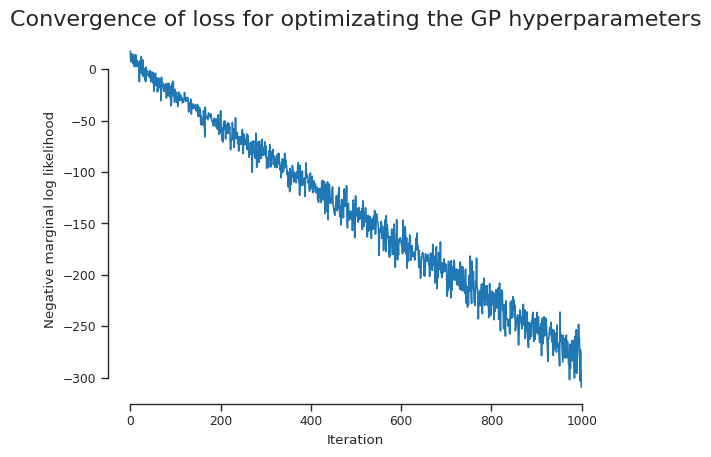

In [32]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel("Iteration")
ax.set_ylabel("Negative marginal log likelihood")
ax.set_title("Convergence of loss for optimizating the GP hyperparameters", fontsize=16)
sns.despine(trim=True);

In [35]:
gp = build_gp(trained_params, X_train_scaled)

predicted_values = gp.predict(y_train_scaled, X_test_scaled)

RMSE = np.sqrt(np.mean((predicted_values - y_test_scaled)**2))
print("RMSE:", RMSE)

RMSE: 0.41129178


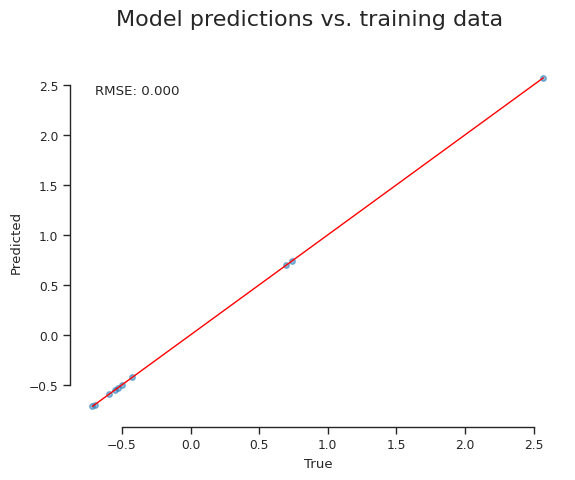

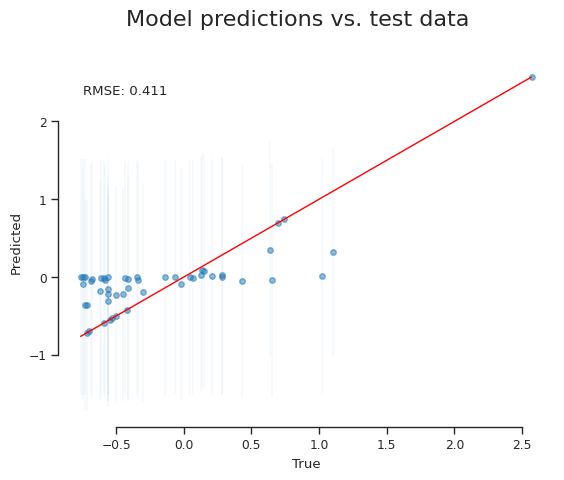

In [41]:
_, cond_gp = gp.condition(y_train_scaled, X_train_scaled)
means_train = cond_gp.mean
stdevs_train = jnp.sqrt(cond_gp.variance)

_, cond_gp = gp.condition(y_train_scaled, X_test_scaled)
means_test = cond_gp.mean
stdevs_test = jnp.sqrt(cond_gp.variance)

rmse = lambda y, y_hat: jnp.sqrt(jnp.mean((y - y_hat)**2))

fig, ax = plt.subplots()
fig.suptitle('Model predictions vs. training data', fontsize=16)
ax.errorbar(y_train_scaled, means_train, yerr=2 * stdevs_train, fmt='o', ms=4, alpha=0.5, lw=0.1)
ax.plot([y_train_scaled.min(), y_train_scaled.max()], [y_train_scaled.min(), y_train_scaled.max()], "r-", lw=1, zorder=100)
ax.annotate(f"RMSE: {rmse(y_train_scaled, means_train):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')
sns.despine(trim=True, ax=ax)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')

fig, ax = plt.subplots()
fig.suptitle('Model predictions vs. test data', fontsize=16)
ax.errorbar(y_test_scaled, means_test, yerr=2 * stdevs_test, fmt='o', ms=4, alpha=0.5, lw=0.1)
ax.plot([y_test_scaled.min(), y_test_scaled.max()], [y_test_scaled.min(), y_test_scaled.max()], "r-", lw=1, zorder=100)
ax.annotate(f"RMSE: {rmse(y_test_scaled, means_test):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')
sns.despine(trim=True, ax=ax)
ax.set_xlabel('True')
ax.set_ylabel('Predicted');


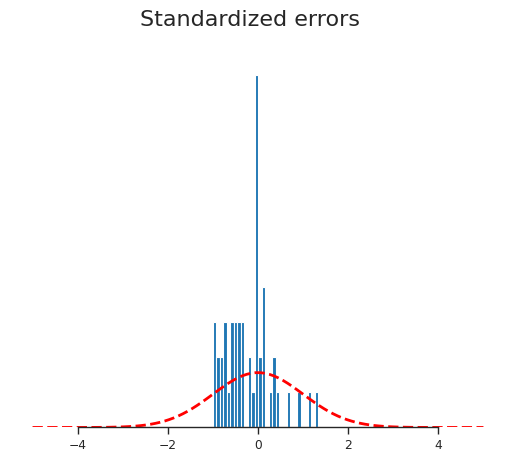

In [42]:
standardized_errors = (y_test_scaled - means_test) / stdevs_test

fig, ax = plt.subplots()
fig.suptitle('Standardized errors', fontsize=16)
ax.hist(standardized_errors, bins=30, density=True)
x = jnp.linspace(-5, 5, 100)
y = jnp.exp(-0.5 * x**2) / jnp.sqrt(2 * jnp.pi)
ax.plot(x, y, 'r--', lw=2)
ax.set_yticks([])
sns.despine(trim=True, ax=ax, left=True);

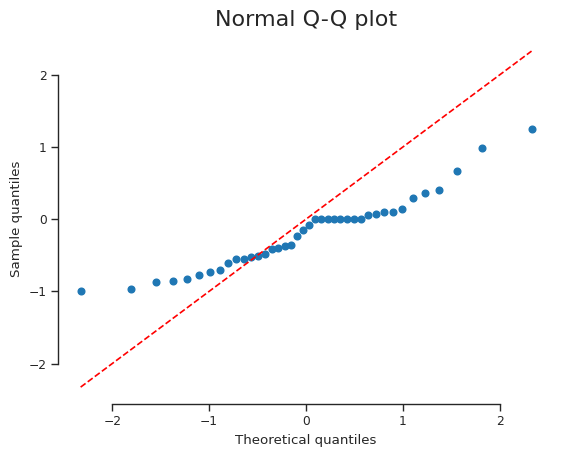

In [43]:
quantiles = jnp.linspace(0.01, 0.99, 40)
normal_quantiles = jstats.norm.ppf(quantiles)
error_quantiles = jnp.quantile(standardized_errors, quantiles, axis=0)

fig, ax = plt.subplots()
ax.plot(normal_quantiles, error_quantiles, 'o')
ax.plot(normal_quantiles, normal_quantiles, 'r--')
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Sample quantiles')
ax.set_title('Normal Q-Q plot', fontsize=16)
sns.despine(trim=True, ax=ax);

## Part D - Randomly collect more training data

+ Pick the next point from the Sobol sequence, map it to $[-5, 10] \times [0, 15]$, and evaluate the Brannin function using the Python wrapper you built in Part A.
+ Add the new point to the training data and rebuild the surrogate model.
+ Test your model on the test data generated in Part B.
+ Calculate and report the root mean squared error on the test data.
+ Iterate this process for 190 iterations.
+ Plot the root mean squared error as a function of the number of training points (not the number of iterations).
+ For the last iteration, plot the predictions on the test data along with the true values.
+ For the last iteration, calculate the stanardized errors on the test data and plot them.
+ For the last iteration, plot the quantile-quantile plot of the standardized errors.

In [45]:
# Your answer here, with as many code cells as you need.

RMSEs = np.zeros(190)

for i in range(190):
  n_train = 10 + i

  sobol_train = qmc.Sobol(d=2, scramble=False).random(n_train)

  lower_bounds = [-5, 0]
  upper_bounds = [10, 15]

  sobol_train = qmc.scale(sobol_train, lower_bounds, upper_bounds)

  values_train = branin_v(sobol_train)

  scale_x, _ = build_standard_scaler(sobol_train)
  scale_y, _ = build_standard_scaler(values_train)

  X_train_scaled = scale_x(sobol_train)
  y_train_scaled = scale_y(values_train)

  gp = build_gp(trained_params, X_train_scaled)

  predicted_values = gp.predict(y_train_scaled, X_test_scaled)

  RMSE = np.sqrt(np.mean((predicted_values - y_test_scaled)**2))
  RMSEs[i] = RMSE

/usr/local/lib/python3.11/dist-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Text(0, 0.5, 'Root mean squared error')

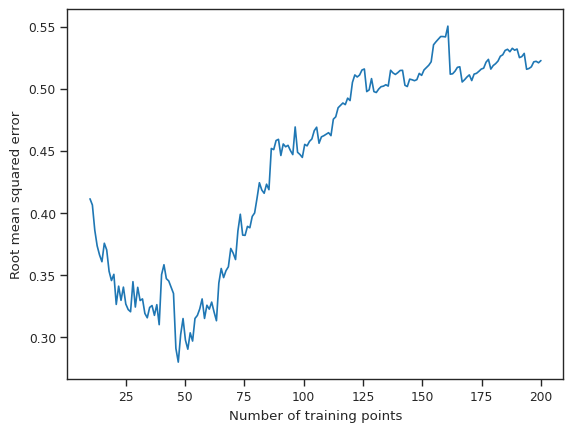

In [47]:
xs = np.linspace(10, 200, 190)

fig, ax = plt.subplots()
ax.plot(xs, RMSEs)
ax.set_xlabel("Number of training points")
ax.set_ylabel("Root mean squared error")

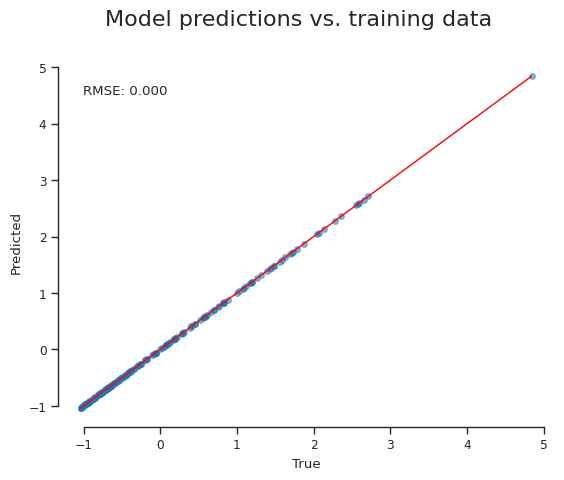

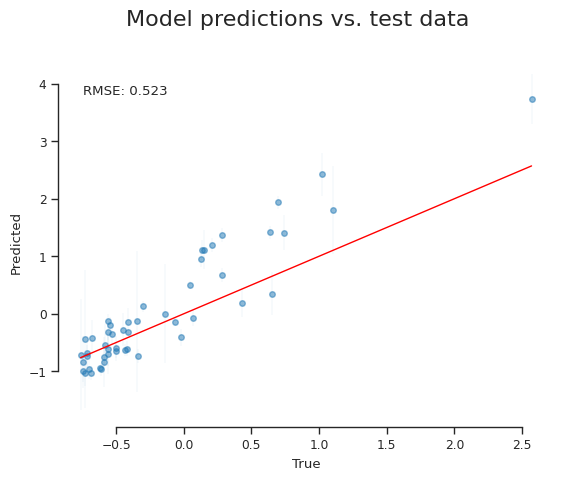

In [48]:
_, cond_gp = gp.condition(y_train_scaled, X_train_scaled)
means_train = cond_gp.mean
stdevs_train = jnp.sqrt(cond_gp.variance)

_, cond_gp = gp.condition(y_train_scaled, X_test_scaled)
means_test = cond_gp.mean
stdevs_test = jnp.sqrt(cond_gp.variance)

rmse = lambda y, y_hat: jnp.sqrt(jnp.mean((y - y_hat)**2))

fig, ax = plt.subplots()
fig.suptitle('Model predictions vs. training data', fontsize=16)
ax.errorbar(y_train_scaled, means_train, yerr=2 * stdevs_train, fmt='o', ms=4, alpha=0.5, lw=0.1)
ax.plot([y_train_scaled.min(), y_train_scaled.max()], [y_train_scaled.min(), y_train_scaled.max()], "r-", lw=1, zorder=100)
ax.annotate(f"RMSE: {rmse(y_train_scaled, means_train):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')
sns.despine(trim=True, ax=ax)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')

fig, ax = plt.subplots()
fig.suptitle('Model predictions vs. test data', fontsize=16)
ax.errorbar(y_test_scaled, means_test, yerr=2 * stdevs_test, fmt='o', ms=4, alpha=0.5, lw=0.1)
ax.plot([y_test_scaled.min(), y_test_scaled.max()], [y_test_scaled.min(), y_test_scaled.max()], "r-", lw=1, zorder=100)
ax.annotate(f"RMSE: {rmse(y_test_scaled, means_test):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')
sns.despine(trim=True, ax=ax)
ax.set_xlabel('True')
ax.set_ylabel('Predicted');

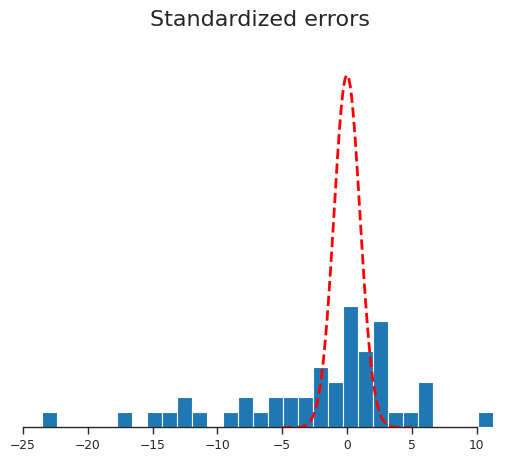

In [49]:
standardized_errors = (y_test_scaled - means_test) / stdevs_test

fig, ax = plt.subplots()
fig.suptitle('Standardized errors', fontsize=16)
ax.hist(standardized_errors, bins=30, density=True)
x = jnp.linspace(-5, 5, 100)
y = jnp.exp(-0.5 * x**2) / jnp.sqrt(2 * jnp.pi)
ax.plot(x, y, 'r--', lw=2)
ax.set_yticks([])
sns.despine(trim=True, ax=ax, left=True);

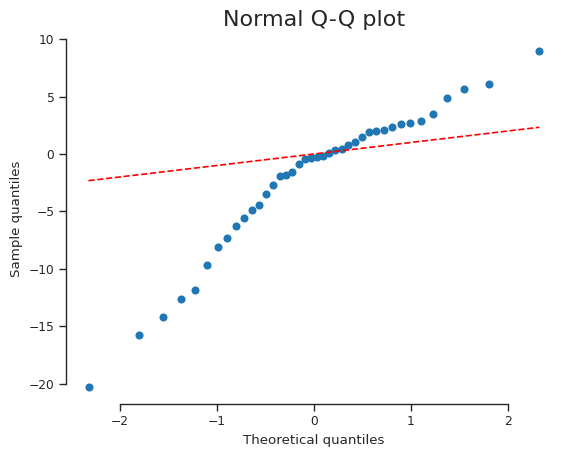

In [50]:
quantiles = jnp.linspace(0.01, 0.99, 40)
normal_quantiles = jstats.norm.ppf(quantiles)
error_quantiles = jnp.quantile(standardized_errors, quantiles, axis=0)

fig, ax = plt.subplots()
ax.plot(normal_quantiles, error_quantiles, 'o')
ax.plot(normal_quantiles, normal_quantiles, 'r--')
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Sample quantiles')
ax.set_title('Normal Q-Q plot', fontsize=16)
sns.despine(trim=True, ax=ax);

## Part E - Active learning

Use uncertainty sampling to select the next point to evaluate. Implement it as follows:

+ Start with a clean surrogate model using only the $n=10$ initial training points.
+ On each iteration:
    - Generate $n_{\text{candidate}} = 1000$ points from the Sobol sequence.
    - Calculate the predictive variance of the surrogate model at each candidate point.
    - Select the candidate point with the highest predictive variance.
    - Evaluate the legacy code at the selected candidate point (don't forget to scale it to $[-5, 10] \times [0, 15]$).
    - Add the new point to the training data and rebuild the surrogate model.
    - Test your model on the test data generated in Part B.
    - Calculate and report the root mean squared error on the test data.
+ Iterate this process for 190 iterations.
+ Plot the root mean squared error as a function of the number of training points (not the number of iterations).
+ For the last iteration, plot the predictions on the test data along with the true values.
+ For the last iteration, calculate the stanardized errors on the test data and plot them.
+ For the last iteration, plot the quantile-quantile plot of the standardized errors.
+ Plot the root mean squared error as a function of the number of training points for the random sampling case. Compare it with the random sampling case.
+ Did you do better with active learning than with random sampling? Why?
+ Plot the points that were selected by the active learning process. Where are most of them located?

In [ ]:
# Your answer here, with as many code cells as you need.

## Part F - Optimization

Now suppose that what you wanted to do was to find the minimum of the legacy code.

+ Start with a clean surrogate model using only the $n=10$ initial training points.
+ On each iteration:
    - Generate $n_{\text{candidate}} = 1000$ points from the Sobol sequence.
    - Calculate the predictive mean $\mu(x)$ and standard deviation $\sigma(x)$ of the surrogate model at each candidate point.
    - Select the candidate point with the highest expected improvement:

        $$
        \text{EI}(x) = \mathbb{E}[\max(f_{\text{min}} - f(x), 0)] = \sigma(x) [\gamma(x) \Phi(\gamma(x)) + \phi(\gamma(x))]
        $$

        where $f_{\text{min}}$ is the minimum value of the Brannin function found so far, $\gamma(x) = (f_{\text{min}} - \mu(x)) / \sigma(x)$, $\Phi$ is the cumulative distribution function of the standard normal distribution, and $\phi$ is the probability density function of the standard normal distribution.

    - Add the new point to the training data and rebuild the surrogate model.
+ Iterate this process for 50 iterations.
+ Plot the expected improvement as a function of the number of training points.
+ Plot the minimum value of the Brannin function found so far as a function of the number of training points.
+ Plot the points that were selected by the optimization process. Where are most of them located?

In [ ]:
# Your answer here, with as many code cells as you need.

## Part G - Multi-fidelity approach

Now, let's pretend that we have access to a low-fidelity version of the legacy code.
Pick this:

$$
f_{\text{low}}(x) = (x_2 - 5.1 x_1^2 / 4\pi^2 + 5x_1/\pi - 6)^2.
$$

Notice that this is very similar to the legacy code, but it misses the cosine term and the constant term.
Let's pretend that the low-fidelity code is much cheaper to evaluate than the high-fidelity code.
We can use the low-fidelity code to build a surrogate model and then use the high-fidelity code to correct the surrogate model.

+ Generate $n_{\text{low}}=200$ points from the Sobol sequence and evaluate the low-fidelity code at these points.
+ Build a Gaussian process surrogate model using the low-fidelity data.
+ Build a multi-fidelity Gaussian process surrogate model using the $n=10$ initial training points and the low-fidelity surrogate mean. Hint: Just make your covariance function:

    $$
    k(x, x') = k_1(x, x')k_2(f_{\text{low}}(x), f_{\text{low}}(x')),
    $$

    where $k_1$ is the squared exponential kernel and $k_2$ is the squared exponential kernel with different hyper-parameters. Use one variance hyper-parameter (set the other to 1).
+ Iteratively add more points using uncertainty sampling as in Part E. Go again to 200 points.
+ Plot the root mean squared error as a function of the number of training points and compare to the single-fidelity case.
+ Plot the points that were selected by the multi-fidelity active learning process. Where are most of them located?

In [ ]:
# Your answer here, with as many code cells as you need.

# Problem 2 - The permutation group

The purpose of this problem is to teach you the basics of the permutation group and its representations.

The permutation group is particularly important for two reasons.
First, according to Cayley's theorem, every finite group is isomorphic to a subgroup of a permutation group.
Second, we will see that every permutation group has a representation as a matrix group with the operation being the common matrix multiplication.
Therefore, **every finite group has a matrix representation**.

The permutation group $S_n$ is the group of all permutations of $n$ elements.
Each element of the group is a bijective function that maps $\{1, 2, \ldots, n\}$ to itself.
Bijective means one-to-one and onto, i.e., each element of the set is mapped to a unique element of the set and each element of the set is mapped to.
For example, an element of $S_3$ is the function $\sigma: \{1, 2, 3\} \to \{1, 2, 3\}$ defined by $\sigma(1) = 2$, $\sigma(2) = 3$, and $\sigma(3) = 1$.

The group operation is composition of functions.
The identity element is the function that maps each element to itself.
The inverse of a function is the function that undoes the permutation.

## Part A

How many elements does $S_n$ have?

## Part B

One way to represent permuations is as a 2-row matrix where the first row is the input and the second row is the output.
For example, the permutation $\sigma$ defined above can be represented as:

$$
\sigma = \begin{bmatrix}
1 & 2 & 3 \\
2 & 3 & 1
\end{bmatrix}
$$

Represent as such a matrix the permutation that maps 1 to 3, 2 to 1, and 3 to 2.

## Part C

A cycle is a permutation that moves some elements and leaves the others fixed.
For example, the permutation:

$$
\sigma = \begin{bmatrix}
1 & 2 & 3 & 4\\
2 & 3 & 1 & 4
\end{bmatrix}
$$

in $S_4$ is a cycle. There is a cycle notation that is more compact.
We can also write:

$$
\sigma = (1, 2, 3)
$$

And we mean that 1 is mapped to 2, 2 is mapped to 3, and 3 is mapped to 1.
The cycle notation is not unique. For example, we could also write:

$$
\sigma = (2, 3, 1)
$$

And we would mean the same permutation.
Write the permutation:

$$
\sigma = \begin{bmatrix}
1 & 2 & 3 & 4\\
2 & 1 & 4 & 3
\end{bmatrix}
$$

in cycle notation.

## Part D

Any permutation can be written as a product of disjoint cycles.
For example, the permutation:

$$
\sigma = \begin{bmatrix}
1 & 2 & 3 & 4\\
2 & 1 & 4 & 3
\end{bmatrix}
$$

can be written as:

$$
\sigma = (1, 2)(3, 4)
$$

To figure out this decomposition, you can start with the first element and follow the permutation until you get back to the first element.
Then you write the cycle and remove the elements that are part of the cycle.
You repeat this process until you have written all the cycles.
Write the permutation:

$$
\sigma = \begin{bmatrix}
1 & 2 & 3 & 4 & 5 & 6\\
2 & 1 & 4 & 3 & 6 & 5
\end{bmatrix}
$$

in $S_6$ as a product of disjoint cycles.

## Part E

A transposition is a cycle of length 2.
Like $(1, 2)$ or $(3, 4)$.
Any permutation can be written as a product of transpositions.

For example, take the permutation

$$
\sigma = \begin{bmatrix}
1 & 2 & 3 & 4 & 5\\
4 & 1 & 5 & 2 & 3
\end{bmatrix}
$$

in $S_5$.
First, write it as a product of disjoint cycles:

$$
\sigma = (1, 4, 2)(3, 5).
$$

Then write each cycle as a product of transpositions.
For example,

$$
(1, 4, 2) = (1, 4)(4, 2).
$$

And then you have:

$$
\sigma = (1, 4)(4, 2)(3, 5).
$$

Write the permutation:

$$
\sigma = \begin{bmatrix}
1 & 2 & 3 & 4 & 5\\
2 & 1 & 4 & 5 & 3
\end{bmatrix}
$$

in $S_5$ as a product of transpositions.


## Part F

The number of transpositions in the decomposition of a permutation is always the same.
If the number of transpositions is even, the permutation is called even.
If the number of transpositions is odd, the permutation is called odd.

Is the permutation:

$$
\sigma = \begin{bmatrix}
1 & 2 & 3 & 4 & 5\\
2 & 1 & 4 & 5 & 3
\end{bmatrix}
$$

in $S_5$ even or odd?

## Part G

The set of all even permutations in $S_n$ is a subgroup of $S_n$.
It is called the *alternating group* and denoted by $A_n$.

+ Show that when you multiply two even permutations you get an even permutation. Hint: If you multiply two even permutations, how many transpositions do you get?
+ Show that the identity permutation is even. Hint: How many transpositions do you need to write the identity permutation?
+ Show that the inverse of the transposition $(a, b)$ is itself.
+ Show that the inverse of the transposition $(1, 2)(3, 4)$ is $(1, 2)(3, 4)$.
+ Show that the inverse of the transposition $(1, 2)(2, 3)$ is $(2, 3)(1, 2)$.
+ Argue that the inverse of a an even permutation is even. Hint: Write the permutation as a product of transpositions and generalize the previous results.
+ Argue that $A_n$ is a group and since it is closed under multiplication, it is a subgroup of $S_n$.

## Part H

Now let's represent permutations as square matrices.
A permutation matrix is a square matrix that has exactly one 1 in each row and each column and 0's elsewhere.
For example, the permutation:

$$
\sigma = \begin{bmatrix}
1 & 2 & 3 & 4\\
2 & 1 & 4 & 3
\end{bmatrix}
$$

in $S_4$ can be represented as the permutation matrix:

$$
D(\sigma) = \begin{bmatrix}
0 & 1 & 0 & 0\\
1 & 0 & 0 & 0\\
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0
\end{bmatrix}.
$$

The matrix can act on a one-hot vector representation of the numbers from 1 to $4$.
For example, $2$ is represented as:

$$
D(2) = \begin{bmatrix}
0\\
1\\
0\\
0
\end{bmatrix}.
$$

And the matrix acting on $2$ gives:

$$
D(\sigma)D(2)
= \begin{bmatrix}
0 & 1 & 0 & 0\\
1 & 0 & 0 & 0\\
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0
\end{bmatrix}
\begin{bmatrix}
0\\
1\\
0\\
0
\end{bmatrix}
=
\begin{bmatrix}
1\\
0\\
0\\
0
\end{bmatrix}.
$$

+ Find the matrix representation, $D(\sigma)$ and $D(\tau)$, of the $S_4$ permutations:

    $$
    \sigma = (1, 2)(2, 3)
    $$

    and

    $$
    \tau = (1, 3)(2, 4).
    $$

+ Verify, by direct calculation, that the matrix product $D(\sigma)D(\tau)$ is the matrix representation of the permutation $\sigma \tau$.
+ Find the inverse of the matrix $D(\sigma)$. To which permutation does it correspond? Verify that it is indeed the inverse by multiplying the matrix by its inverse and showing that you get the identity matrix.

## Part E

Using what you know you could create a $3\times 3$ matrix representation of $S_3$ (group of permutations of three objects).
But it actually possible to create a faithful representation that is $2\times 2$, albeit it will be complex.
We will, of course, map the identity permutation to the identity matrix:

$$
D(\text{Id}) = \begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix}.
$$

But where do we map the rest?
Let's start with the cycle $(1, 2, 3)$.
Observe that:

$$
(1,2,3)^2 = (1,2,3)(1,2,3) = (1,3,2).
$$

And once more:

$$
(1,2,3)^3 = (1,2,3)^2(1,2,3) = (1,3,2)(1,2,3) = \text{Id}.
$$

So, we need to find a 2\times 2 matrix $D((1,2,3))$ such that:

$$
D((1,2,3))^3 = \begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix}.
$$

+ Try a diagonal matrix:

    $$
    D((1,2,3)) = \begin{bmatrix}
    a & 0\\
    0 & b
    \end{bmatrix}.
    $$

    Hint: You will need to use complex numbers and the cube root of unity, $\omega = e^{2\pi i/3}$.

+ What is the matrix representation of $(1, 3, 2)$? Hint: Use the fact that $(1, 3, 2) = (1, 2, 3)^2$.
+ Pick that the matrix representation of $(1,2)$ to be:

    $$
    D((1,2)) = \begin{bmatrix}
    0 & 1\\
    1 & 0
    \end{bmatrix}.
    $$

    Verify that $D((1,2))^2 = \text{Id}$.
+ Find the matrix representation of $D((2,3))$. Hint: Use the fact that $(2,3) = (1, 2)(1, 2, 3)$.
+ Find the matrix representation of $D((1,3))$.

